In [1]:
import warnings
warnings.simplefilter('ignore')
from neurocaps.extraction import TimeseriesExtractor
from neurocaps.analysis import CAP, merge_dicts

help(TimeseriesExtractor)
parcel_approach = {"Schaefer": {"n_rois": 100, "yeo_networks": 7, "resolution_mm": 2}}
#parcel_approach = {"AAL": {"version": "SPM12"}}

ncol = parcel_approach["Schaefer"]["n_rois"] if "Schaefer" in parcel_approach.keys() else 116
extractor = TimeseriesExtractor(parcel_approach=parcel_approach)

Help on class TimeseriesExtractor in module neurocaps.extraction.timeseriesextractor:

class TimeseriesExtractor(neurocaps._utils._timeseriesextractor_internals._timeseriesextractorgetter._TimeseriesExtractorGetter)
 |  TimeseriesExtractor(space: str = 'MNI152NLin2009cAsym', standardize: Union[bool, str] = 'zscore_sample', detrend: bool = True, low_pass: Optional[float] = None, high_pass: Optional[float] = None, parcel_approach: Dict[str, Dict] = {'Schaefer': {'n_rois': 400, 'yeo_networks': 7, 'resolution_mm': 1}}, use_confounds: bool = True, confound_names: Optional[List[str]] = None, fwhm: Optional[float] = None, fd_threshold: Optional[float] = None, n_acompcor_separate: Optional[int] = None, dummy_scans: Optional[int] = None) -> None
 |  
 |  **Timeseries Extractor Class**
 |  
 |  Initializes the TimeseriesExtractor class.
 |  
 |  Parameters
 |  ----------
 |  space : str, default="MNI152NLin2009cAsym"
 |      The standard template space that the preprocessed bold data is register

In [2]:
extractor.parcel_approach

{'Schaefer': {'n_rois': 100,
  'yeo_networks': 7,
  'resolution_mm': 2,
  'maps': 'C:\\Users\\donis/nilearn_data\\schaefer_2018\\Schaefer2018_100Parcels_7Networks_order_FSLMNI152_2mm.nii.gz',
  'nodes': ['LH_Vis_1',
   'LH_Vis_2',
   'LH_Vis_3',
   'LH_Vis_4',
   'LH_Vis_5',
   'LH_Vis_6',
   'LH_Vis_7',
   'LH_Vis_8',
   'LH_Vis_9',
   'LH_SomMot_1',
   'LH_SomMot_2',
   'LH_SomMot_3',
   'LH_SomMot_4',
   'LH_SomMot_5',
   'LH_SomMot_6',
   'LH_DorsAttn_Post_1',
   'LH_DorsAttn_Post_2',
   'LH_DorsAttn_Post_3',
   'LH_DorsAttn_Post_4',
   'LH_DorsAttn_Post_5',
   'LH_DorsAttn_Post_6',
   'LH_DorsAttn_PrCv_1',
   'LH_DorsAttn_FEF_1',
   'LH_SalVentAttn_ParOper_1',
   'LH_SalVentAttn_FrOperIns_1',
   'LH_SalVentAttn_FrOperIns_2',
   'LH_SalVentAttn_PFCl_1',
   'LH_SalVentAttn_Med_1',
   'LH_SalVentAttn_Med_2',
   'LH_SalVentAttn_Med_3',
   'LH_Limbic_OFC_1',
   'LH_Limbic_TempPole_1',
   'LH_Limbic_TempPole_2',
   'LH_Cont_Par_1',
   'LH_Cont_PFCl_1',
   'LH_Cont_pCun_1',
   'LH_Cont_C

In [3]:
help(extractor.get_bold)

Help on method get_bold in module neurocaps.extraction.timeseriesextractor:

get_bold(bids_dir: Union[str, os.PathLike], task: str, session: Union[int, str, NoneType] = None, runs: Optional[List[int]] = None, condition: Optional[str] = None, tr: Union[int, float, NoneType] = None, run_subjects: Optional[List[str]] = None, exclude_subjects: Optional[List[str]] = None, pipeline_name: Optional[str] = None, n_cores: Optional[int] = None, verbose: bool = True, flush_print: bool = False, exclude_niftis: Optional[List[str]] = None) -> None method of neurocaps.extraction.timeseriesextractor.TimeseriesExtractor instance
    **Get BOLD Data**
    
    Collects files needed to extract timeseries data from NIfTI files for BIDS-compliant datasets containing a
    derivatives folder. This function assumes that your BOLD data was preprocessed using a standard
    preprocessing pipeline such as fMRIPrep.
    
    Parameters
    ----------
    bids_dir : Path
        Path to a BIDS compliant directory.

In [4]:
# Attributes

print(dir(extractor))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_get_files', '_parcel_approach', '_setup_extraction', '_signal_clean_info', '_space', 'get_bold', 'n_cores', 'parcel_approach', 'signal_clean_info', 'space', 'subject_ids', 'subject_timeseries', 'task_info', 'timeseries_to_pickle', 'visualize_bold']


In [5]:
# Example structure of what extractor.get_bold() produces; the rows would be equal to the TRs and the columnn would be equal to the number of nodes. 
# So, all subjects would have the same column length which depends on the number inputted in n_nodes when initializing TimeseriesExtractor
# For visualization purposes, I will print out 5 by 5 arrays to show the general structure
import numpy as np

print({str(x) : {f"run-{y}": np.random.rand(5,5) for y in range(1,4)} for x in range(1,2)})

{'1': {'run-1': array([[0.97614507, 0.93535852, 0.03399463, 0.05836511, 0.897251  ],
       [0.75653199, 0.87752202, 0.59462604, 0.71028799, 0.95592202],
       [0.55703672, 0.68855881, 0.86761108, 0.2671058 , 0.5718294 ],
       [0.0589738 , 0.5072783 , 0.39998525, 0.06649708, 0.69081667],
       [0.28667153, 0.82585346, 0.35013958, 0.55749212, 0.17306108]]), 'run-2': array([[0.30560103, 0.50925469, 0.27098755, 0.79426671, 0.34600023],
       [0.44702727, 0.74563332, 0.78581647, 0.20355373, 0.55523511],
       [0.16287357, 0.78631104, 0.11030566, 0.19472107, 0.10078079],
       [0.34913901, 0.57455978, 0.67030946, 0.88038155, 0.98542099],
       [0.3437632 , 0.13635575, 0.33976546, 0.08424789, 0.38688926]]), 'run-3': array([[0.21381908, 0.36502893, 0.17098303, 0.17334713, 0.41630622],
       [0.49814857, 0.63030561, 0.46685639, 0.90383607, 0.60960369],
       [0.1994739 , 0.01570351, 0.82786188, 0.08622543, 0.50752171],
       [0.93192737, 0.37718587, 0.42221299, 0.44264995, 0.4165505

In [6]:
# Generating a fuller subject timeseries for later cap analysis
extractor.subject_timeseries = {str(x) : {f"run-{y}": np.random.rand(50,ncol) for y in range(1,4)} for x in range(1,11)}

In [7]:
extractor.parcel_approach = parcel_approach

In [8]:
extractor.parcel_approach 

{'Schaefer': {'n_rois': 100,
  'yeo_networks': 7,
  'resolution_mm': 2,
  'maps': 'C:\\Users\\donis/nilearn_data\\schaefer_2018\\Schaefer2018_100Parcels_7Networks_order_FSLMNI152_2mm.nii.gz',
  'nodes': ['LH_Vis_1',
   'LH_Vis_2',
   'LH_Vis_3',
   'LH_Vis_4',
   'LH_Vis_5',
   'LH_Vis_6',
   'LH_Vis_7',
   'LH_Vis_8',
   'LH_Vis_9',
   'LH_SomMot_1',
   'LH_SomMot_2',
   'LH_SomMot_3',
   'LH_SomMot_4',
   'LH_SomMot_5',
   'LH_SomMot_6',
   'LH_DorsAttn_Post_1',
   'LH_DorsAttn_Post_2',
   'LH_DorsAttn_Post_3',
   'LH_DorsAttn_Post_4',
   'LH_DorsAttn_Post_5',
   'LH_DorsAttn_Post_6',
   'LH_DorsAttn_PrCv_1',
   'LH_DorsAttn_FEF_1',
   'LH_SalVentAttn_ParOper_1',
   'LH_SalVentAttn_FrOperIns_1',
   'LH_SalVentAttn_FrOperIns_2',
   'LH_SalVentAttn_PFCl_1',
   'LH_SalVentAttn_Med_1',
   'LH_SalVentAttn_Med_2',
   'LH_SalVentAttn_Med_3',
   'LH_Limbic_OFC_1',
   'LH_Limbic_TempPole_1',
   'LH_Limbic_TempPole_2',
   'LH_Cont_Par_1',
   'LH_Cont_PFCl_1',
   'LH_Cont_pCun_1',
   'LH_Cont_C

In [9]:
# Save randomly generated data in directory where jupyter notebook is running

import os, joblib

output_dir = os.path.dirname(__vsc_ipynb_file__)

extractor.timeseries_to_pickle(output_dir=output_dir, file_name="sample_for_neurocaps_demo_timeseries.pkl")

with open("sample_for_neurocaps_demo_timeseries.pkl", "rb") as f:
    subject_timeseries = joblib.load(f)


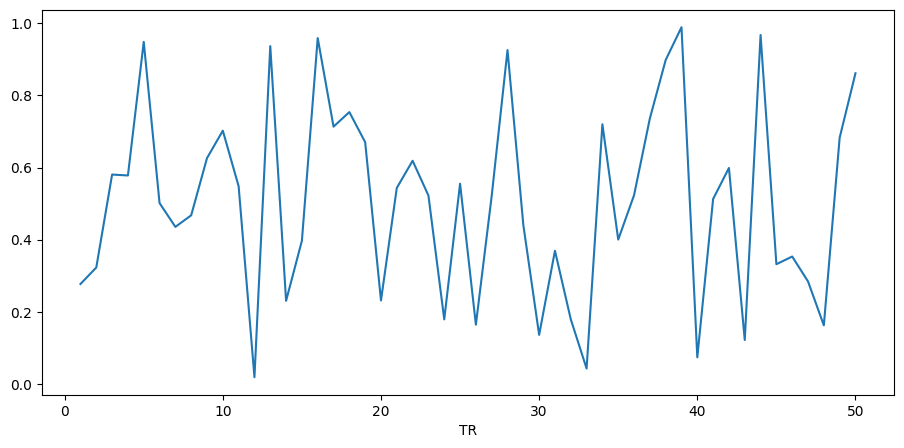

In [10]:
# Visualize Bold at node level

extractor.visualize_bold(subj_id="1",run=1, roi_indx=0)

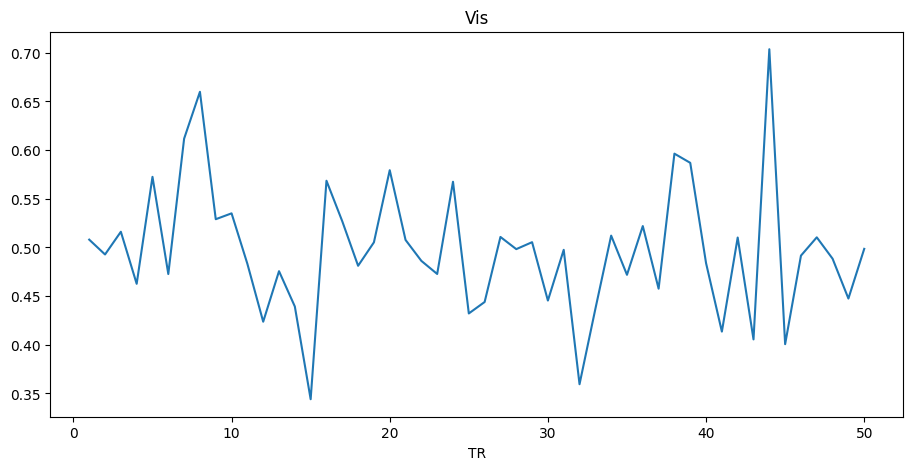

In [11]:
# Visualize Bold at network level
if ncol == 116:
    extractor.visualize_bold(subj_id="1",run=1, region="Cerebelum")
else:
    extractor.visualize_bold(subj_id="1",run=1, region="Vis")

In [12]:
# Performing Cap analysis with all subjects 
cap_analysis = CAP(n_clusters=3)
cap_analysis.get_caps(subject_timeseries=extractor.subject_timeseries)

In [13]:
cap_analysis.parcel_approach

In [14]:
subject_timeseries.keys()

dict_keys(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])

Optimal cluster size for B is 7.



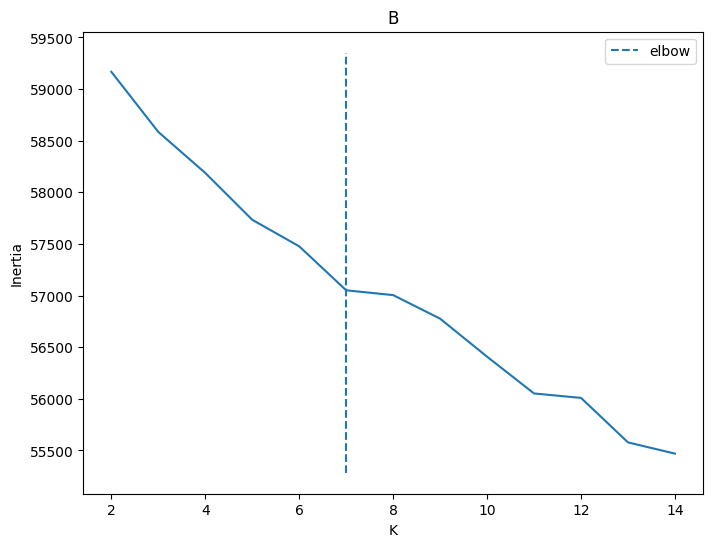

KeyError: 'A'

In [15]:
# Performing Cap analysis with groups, list of n_clusters, and elbow cluster selection method

cap_analysis = CAP(groups={"A": ["1","2","3","5"], "B": ["4","6","7","8","9","10"]}, n_clusters=list(range(2,15)),
                   cluster_selection_method="elbow")

# When elbow method is specified, the associated plots will be shown, furthermore, the saved kmeans model for each group will automatically save to the optimal cluster size

cap_analysis.get_caps(subject_timeseries="sample_for_neurocaps_demo_timeseries.pkl", runs=[1,2], show_figs=True)

In [ ]:
# Performing Cap analysis with groups, list of n_clusters, and silhouette cluster selection method

cap_analysis = CAP(groups={"A": ["1","2","3","5"], "B": ["4","6","7","8","9","10"]}, n_clusters=list(range(2,4)),
                   cluster_selection_method="silhouette")

cap_analysis.get_caps(subject_timeseries="sample_for_neurocaps_demo_timeseries.pkl")

# kmeans model automatically save to the optimal size
cap_analysis.kmeans

In [ ]:
cap_analysis.parcel_approach = parcel_approach

In [ ]:
# Visualize Caps
cap_analysis.caps2plot(subplots=True, xlabel_rotation=90, sharey=True, borderwidths=10)

In [ ]:
# Visualize Caps
cap_analysis.caps2plot(subplots=True, xlabel_rotation=90, hspace=0.6, tight_layout=False, sharey = False)

In [ ]:
# Change scope from network to nodes

cap_analysis.caps2plot(subplots=False, yticklabels_size=14, wspace = 0.1, visual_scope="nodes", xlabel_rotation=90,
                       xticklabels_size = 14, hspace = 0.6, tight_layout = False, hemisphere_labels=True,
                       borderwidths=10, set_xlim = (-20, 120), linewidths=2)

In [ ]:
cap_analysis._region_caps

In [ ]:
cap_analysis.caps2plot(subplots=False, yticklabels_size=5, wspace = 0.1, visual_scope="regions", xlabel_rotation=90,
                       xticklabels_size = 5, hspace = 0.6, tight_layout = False)

In [ ]:
cap_analysis.caps2plot(subplots=False, yticklabels_size=5, wspace = 0.1, visual_scope="nodes", xlabel_rotation=90,
                       xticklabels_size = 5, hspace = 0.6, tight_layout = False)

In [ ]:
# Get regular heatmap 
cap_analysis.caps2plot(subplots=True, visual_scope="regions", plot_options="heatmap", borderwidths=10)
cap_analysis.caps2plot(subplots=True, visual_scope="nodes", plot_options="heatmap", hemisphere_labels = True)

In [ ]:
cap_analysis.calculate_metrics(subject_timeseries=extractor.subject_timeseries,tr=2,metrics="persistence",
                               return_df=True)

In [ ]:
# Performing Cap analysis without groups or cluster selection method

cap_analysis = CAP(parcel_approach=extractor.parcel_approach, n_clusters=6)
cap_analysis.get_caps(subject_timeseries="sample_for_neurocaps_demo_timeseries.pkl")

# Invalid plotting keywords will be ignored and plotting will continue
cap_analysis.caps2plot(subplots=True, wspace = 0.1, hspace = 0.5, ncol=3, suffix_title="- Positive Valence", y = -3,
                       xlabel_rotation=90, tight_layout=False, yticklabels_size=8, xticklabels_size=8)

In [ ]:
cap_analysis.caps2plot(visual_scope="nodes", plot_options="outer product", suffix_title="- Positive Valence", ncol=3, sharey=False, subplots=True, xlabel_rotation = 90, tight_layout=False, hspace = 0.4)

In [ ]:
# Individual plots. In the event you wnat to merge TRs from two dictionaries conatining the same subject to find common CAPs across a task
subject_timeseries_1 = {str(x) : {f"run-{y}": np.random.rand(100,ncol) for y in range(1,4)} for x in range(1,11)}
subject_timeseries_2 = {str(x) : {f"run-{y}": np.random.rand(100,ncol) for y in range(1,4)} for x in range(1,7)}
# Includes `output_dir` and `file_name` parameters to save merge dictionary as a pickle file

# Returns combined dictionary as well as the reduced subject dictionaries containing only the subjects present in the combined
all_dicts = merge_dicts(subject_timeseries_list=[subject_timeseries_1, subject_timeseries_2],
                        return_combined_dict=True, return_reduced_dicts=True)
# Only the combined subject dictionary
subject_timeseries_combined = merge_dicts(subject_timeseries_list=[subject_timeseries_1, subject_timeseries_2],
                                          return_combined_dict=True, return_reduced_dicts=False)

print(all_dicts["dict_0"].keys())
print(all_dicts["dict_1"].keys())
print(all_dicts["combined"].keys())

In [ ]:
cap_analysis = CAP(parcel_approach=extractor.parcel_approach, n_clusters=3)
cap_analysis.get_caps(subject_timeseries=subject_timeseries_combined)
cap_analysis.caps2plot(xlabel_rotation=90)

In [ ]:
cap_analysis.caps2plot(visual_scope="nodes", plot_options="outer product", xlabel_rotation = 90)

In [ ]:
# Performing Caps analysis with no groups and no cluster selection method
cap_analysis = CAP(parcel_approach=extractor.parcel_approach, n_clusters=6)
cap_analysis.get_caps(subject_timeseries=extractor.subject_timeseries)
cap_analysis.caps2plot(visual_scope="regions", plot_options="outer product", subplots=True, fontsize=14,
                       xlabel_rotation=90, tight_layout=False, hspace=0.3)

In [ ]:
import seaborn as sns
sns.diverging_palette(145, 300, s=60, as_cmap=True)
palette = sns.diverging_palette(260, 10, s=80, l=55, n=256, as_cmap=True)
cap_analysis.caps2plot(visual_scope="regions", plot_options="outer product", subplots=True, fontsize=14, ncol=6,
                       sharey=False, tight_layout=False, xlabel_rotation=0, hspace = 0.3, cmap=palette)

In [ ]:
help(cap_analysis.caps2plot)

In [ ]:
output = cap_analysis.calculate_metrics(subject_timeseries=extractor.subject_timeseries,return_df=True, runs=[1,2])
output["temporal fraction"]

In [ ]:
cap_analysis.calculate_metrics(subject_timeseries=extractor.subject_timeseries,return_df=True, runs=[1,2],
                               continuous_runs=True)
output["temporal fraction"]

In [ ]:
help(cap_analysis.calculate_metrics)

In [ ]:
cap_analysis.caps2corr(annot=True ,figsize=(6,4))

import seaborn as sns
palette = sns.diverging_palette(260, 10, s=80, l=55, n=256, as_cmap=True)
cap_analysis.caps2corr(annot=True ,figsize=(6,4))

In [ ]:
# If you experience coverage issues, usually smoothing helps to mitigate these issues

#cap_analysis.caps2surf(fwhm=1, output_dir=output_dir,save_stat_map=True)

cap_analysis.caps2surf(cmap="cold_hot", layout="row",  size=(500, 100))

In [ ]:
from matplotlib.colors import LinearSegmentedColormap
colors = ["#1bfffe", "#00ccff", "#0099ff", "#0066ff", "#0033ff", "#c4c4c4", "#ff6666", 
          "#ff3333", "#FF0000","#ffcc00","#FFFF00"]

# Create the colormap
custom_cmap = LinearSegmentedColormap.from_list("custom_cold_hot", colors, N=256)
cap_analysis.caps2surf(cmap=custom_cmap, size=(500, 100), layout="row")

In [ ]:
radialaxis={"showline": True, "linewidth": 2, "linecolor": "rgba(0, 0, 0, 0.25)", "gridcolor": "rgba(0, 0, 0, 0.25)",
            "ticks": "outside" , "tickfont": {"size": 14, "color": "black"}, "range": [0,0.3],
            "tickvals": [0.1,0.2,0.3]}
cap_analysis.caps2radar(radialaxis=radialaxis, fill="toself", scattersize=10)

In [ ]:
os.remove("sample_for_neurocaps_demo_timeseries.pkl")